# Part 1. Implementing [KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) with numpy.

In [ ]:
# Hint: np.newaxis

## K-neariest neighbor classifier

You are implementing one of the simplest machine learning algorithms, a K-Nearest Neighbor Classifier.
We will apply it to tasks:
- binary classification (that is, only two classes)
- multi-class classification (that is, multiple classes)

Since the method needs a hyperparameter - the number of neighbors, we will select it based on cross-validation.

Before completing the assignment:
- Put the files 'knn.py', 'metrics.py', 'dataset.py', `download_data.sh` into the current directory (/ content /)
- run the file `download_data.sh` to download the data that we will use for training into the data directory (data will appear during the launch of the bash script)

In [ ]:
! bash download_data.sh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

## Load and visualize data

The task has already given the `load_svhn` function, which loads data from disk. It returns data for training and testing as numpy arrays.

We'll use numbers from the Street View House Numbers dataset (SVHN, http://ufldl.stanford.edu/housenumbers/).

In [ ]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

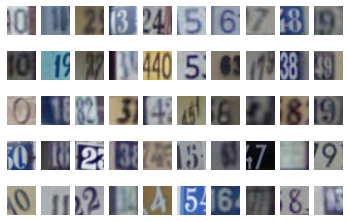

In [ ]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

## First we implement KNN for binary classification

As a binary classification task, we will train a model to distinguish the number 0 from the number 9.

In [ ]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [ ]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1, metric='manhattan')
knn_classifier.fit(binary_train_X, binary_train_y)

### It's time to write some code!

Implement the functions `compute_distances_two_loops`,` compute_distances_one_loop` and `compute_distances_no_loops`
in the file `knn.py`.

These functions build an array of distances between all vectors in the test set and in the training set.
As a result, they must build an array of size `(num_test, num_train)`, where the coordinate `[i][j]` corresponds to the distance between the i-th vector in test (`test[i]`) and the j-th vector in train ( `train[j]`).

**Please note** We will use the measures L1 and L2 as a distance.

In [ ]:
# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [ ]:
# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [ ]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

In [ ]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [ ]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

In [ ]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

## Cross-validation

Let's try to find the best value for the parameter k for the KNN algorithm!

For this we will use k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). We'll split the training data into 5 folds and in turn use each of them as validation data and the rest as training data.

As a final estimate of the effectiveness of k, we will average the F1 score across all folds.
After that, we'll just pick the k value with the best metric value.

In [ ]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1

    pass

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

### Check how well the best k value works on test data

In [ ]:
# TODO Set the best k to the best value found by cross-validation
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

## multi-class classification

We pass to the next stage - classification for each digit.

In [ ]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [ ]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [ ]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Cross-validation again. Now our main metric is accuracy, and we will also average it over all folds.

In [ ]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Final test - classification into 10 classes on the test sample (test data)

If implemented correctly, you should see an accuracy of at least **0.2**.

In [ ]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k, metric='manhattan')
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

### Now it remains to push all 5 files into the repository, and attach the link to your repository to the classroom ... Or, before that, you can try to quickly implement this with sklearn!

# Part 2 (Bonus). Sklearn 

Compare your models for both metrics with similar ones in sklearn.